In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from hft_model import *

# Enforcing the speed limit replication notebook

In [2]:
NRUNS = 10

In [3]:
parameters = {
    # global parameters
    "n_lft": 100,
    "n_hft": 1,
    "ticks": 1000, # 390 ticks per day
    "ticks_per_minute": 2,
    "fundamental_value": 10,
    "lft_sample_size": 0.05,
    "hft_sample_size": 1.0,
    "std_noise": 0.01,
    "std_LFT_vol": 4,
    "max_order_expiration_ticks": 30,
    # lft parameters
    "w_fundamentalists": 1.0, #1
    "w_chartists": 1.4, # 10
    "w_random": 4.0,
    "spread_max": 0.004087, # from Riordann & Storkenmaier 2012
    # hft parameters
    "inventory_target": 1,
    "minimum_price_increment": 0.001,
    "hfm_risk_aversion": 25,
    "hfm_fixed_vol": 1,
    # initial values
    "horizon_min": 1,
    "horizon_max": 8,
    "hfm_horizon_min": 1,
    "hfm_horizon_max": 3,
    "total_hft_money": 2000,
    "hft_speed": 1,
}

# Initialisation

In [4]:
# 1 initalise model objects
high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)

# Simulation

In [5]:
#%%timeit
for seed in range(NRUNS):
    high_frequency_traders, low_frequency_traders, orderbook = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed)

10.0010435
0.0556914369155
-0.0325881827812
0.0773258108887
0.0773258108887
0.14436165029
0.0113720672787
0.0303142556215
0.0303142556215
-0.0654939868473
-0.0561274822935
0.00439379452018
0.00937457931095
-0.00662378634556
-0.0741138583042
-0.0726561337332
-0.0869185567423
0.0198344609981
0.0208017868483
0.0208017868483
-0.0203542577666
0.0317963043308
0.0317963043308
0.0327963043308
0.0327963043308
0.0327963043308
-0.0175177252933
0.0358445910514
0.044933018797
0.044933018797
0.056835337652
0.0368551191275
0.0579002714399
-0.0408168103528
-0.0408168103528
0.0204552355571
0.034310793151
0.0254813369772
-0.0344109357958
0.00497555256357
0.0239287684667
-0.107292027866
-3.78703933048e-05
-0.0992712021105
0.00464830555266
-0.00859082911625
0.0788022810934
-0.0348699493969
-0.0263751253663
0.00741971615796
0.00741971615796
0.0135126443382
-0.0923374729121
-0.0339880679748
0.0211995433343
-0.00410175502372
0.00269696302469
0.0194887233751
0.0194887233751
0.0194887233751
0.0227329298218
0.0

# Data analysis

In [6]:
end_tick_price = orderbook.tick_close_price #[np.mean(prices) for prices in orderbook.transaction_prices_history]
total_tick_volume = [sum(volumes) for volumes in orderbook.transaction_volumes_history]
returns = pd.Series(np.array(end_tick_price)).pct_change()
autocorr_returns = [pd.Series(returns).autocorr(lag=lag) for lag in range(25)]
absolute_returns = pd.Series(returns).abs()
autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(25)]

## Prices, returns & volume

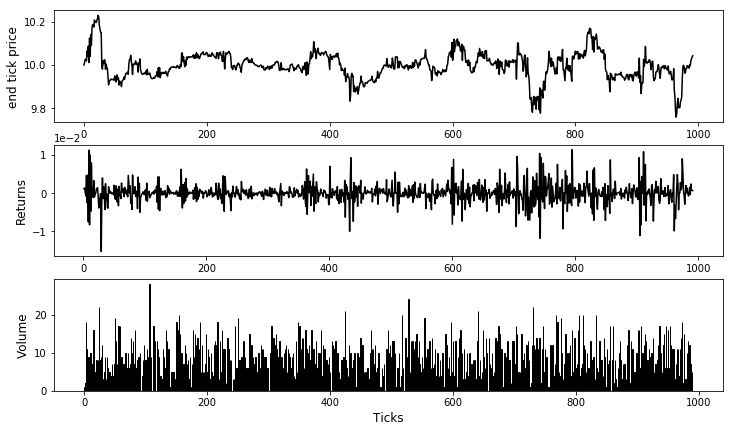

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,7))

ax1.plot(range(len(end_tick_price)), end_tick_price, 'k-')
ax1.set_ylabel('end tick price', fontsize='12')

ax2.plot(range(len(returns)), returns, 'k-')
ax2.set_ylabel('Returns', fontsize='12')

ax3.bar(range(len(total_tick_volume)), total_tick_volume, color='k', edgecolor='k')
ax3.set_ylabel('Volume', fontsize='12')
ax3.set_xlabel('Ticks', fontsize='12')

for ax in [ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
#fig.savefig('hfm_dynamics.png')

## Bid-ask spread & volatility

In [19]:
bid_ask = bid_ask = [((ask - bid) / np.mean([ask, bid])) / 2 for bid, ask in zip(orderbook.highest_bid_price_history, orderbook.lowest_ask_price_history)]
bid_ask = list(filter(lambda x: x >0, bid_ask))
# quoted bid_ask_spread = (Ask - Bid / Mid)
np.mean(bid_ask)

0.00058265061910792908

In [20]:
# is this the correct way 
window = 10
roller_returns = returns.rolling(window)
returns_volatility = roller_returns.std(ddof=0)
returns.std()

0.002588610676204101

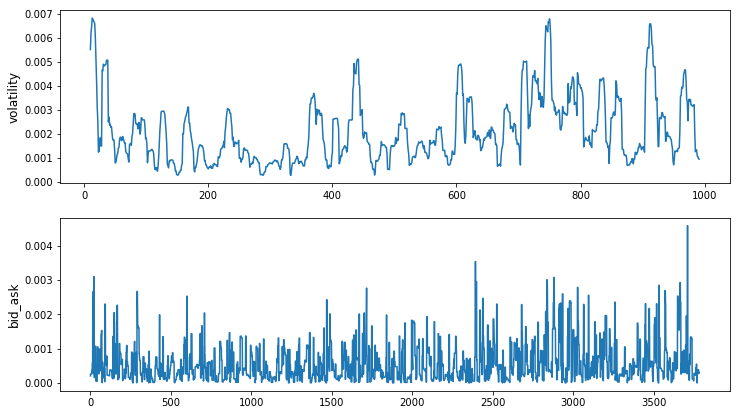

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7))

ax1.plot(range(len(returns_volatility)), returns_volatility)
ax1.set_ylabel('volatility', fontsize='12')

ax2.plot(range(len(bid_ask)), bid_ask)
#ax2.set_ylim(0, 200)
ax2.set_ylabel('bid_ask', fontsize='12')

# Basic financial market stylized facts
## No autocorrelation in returns

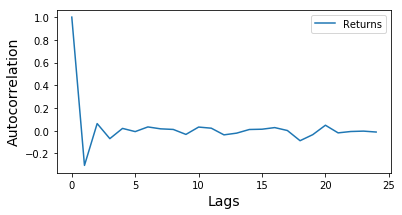

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.plot(range(len(autocorr_returns)), autocorr_returns, label='Returns')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lags', fontsize='14')
#fig.savefig('auto_correlation.png')

## Excess Kurtosis

In [24]:
pd.Series(returns).kurtosis()

5.0890105017204892

## Clustered volatility

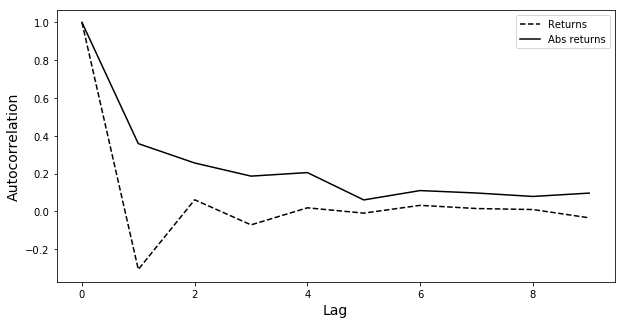

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

lenght = 10

ax1.plot(range(len(autocorr_returns[:lenght])), autocorr_returns[:lenght], 'k--', label='Returns')
ax1.plot(range(len(autocorr_abs_returns[:lenght])), autocorr_abs_returns[:lenght], 'k-', label='Abs returns')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

#fig.savefig('auto_correlations.png')

# % of trades by HFT

In [26]:
def hft_in_match(match):
    for buy_sell in match:
        if 'HFT' in str(buy_sell):
            return True
    return False

In [27]:
amount_matched_orders = 0
hft_participating_orders = 0 
for tick in orderbook.matched_bids_history:
    amount_matched_orders += len(tick)
    for match in tick:
        if hft_in_match(match):
            hft_participating_orders += 1
        
print('total matches ', amount_matched_orders)
print('total hft matches ', hft_participating_orders)
print('percentage hft matches = ', hft_participating_orders / amount_matched_orders)

total matches  4508
total hft matches  944
percentage hft matches =  0.20940550133096716


# HFT Investment

In [28]:
cum_inv = []
for hft in high_frequency_traders:
    cum_inv.append(np.array(hft.var_previous.cum_investment))

AttributeError: 'HFTHistory' object has no attribute 'cum_investment'

In [29]:
agg_cum_inv = np.zeros(len(cum_inv[0]))
for c_i in cum_inv:
    agg_cum_inv += c_i

IndexError: list index out of range

In [30]:
pd.Series(agg_cum_inv)[:100].plot()

NameError: name 'agg_cum_inv' is not defined

# HFT speed

In [31]:
speed = []
for hft in high_frequency_traders:
    speed.append(np.array(hft.var_previous.speed))

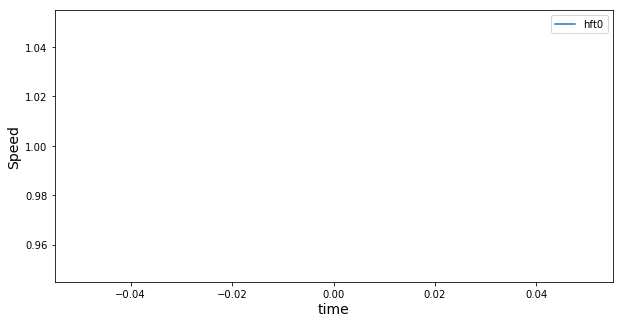

In [32]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

for idx, s in enumerate(speed):
    ax1.plot(range(len(s[:100])), s[:100], label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Speed', fontsize='14')
ax1.set_xlabel('time', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

# HFT profitability

Total wealth. The HFT's track their own total wealth

In [33]:
money = []
stocks = []
locked_in_profits = []
for hft in high_frequency_traders:
    money.append(np.array(hft.var_previous.money))
    stocks.append(np.array(hft.var_previous.stocks))
    locked_in_profits.append(np.array(hft.var_previous.locked_profit))

### Locked in profits

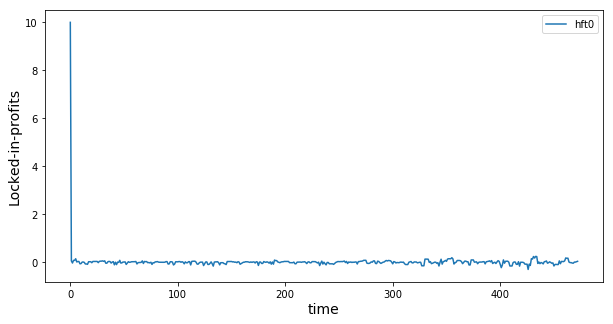

In [34]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

for idx, p in enumerate(locked_in_profits):
    ax1.plot(range(len(p)), p, label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Locked-in-profits', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

In [35]:
sum(locked_in_profits[0])

9.0236420501474512

### Sharpe ratio

In [36]:
def sharpe(periods, mean, standard_deviation):
    return np.sqrt(periods) * (mean / standard_deviation)

In [37]:
all_profits = np.concatenate(locked_in_profits)

In [38]:
sum(all_profits)

9.0236420501474512

In [39]:
#sharpe(len(locked_in_profits[0]), locked_in_profits[0].mean(), locked_in_profits[0].std())
sharpe(len(all_profits), all_profits.mean(), all_profits.std())

0.89471070468615599

### Wealth

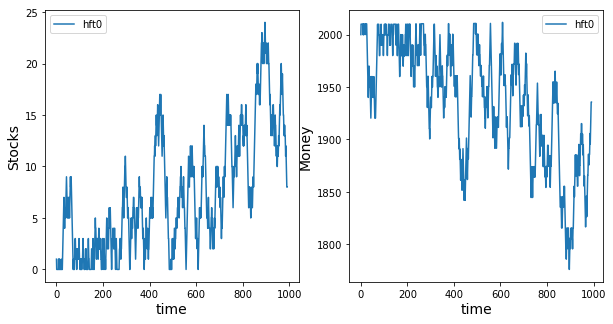

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

timeframe = 10000

for idx, s in enumerate(stocks):
    ax1.plot(range(len(s[:timeframe])), s[:timeframe], label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Stocks', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

for idx, m in enumerate(money):
    ax2.plot(range(len(m[:timeframe])), m[:timeframe], label='hft{}'.format(idx))

ax2.legend(frameon=True, loc='best', framealpha=0.8)
ax2.set_ylabel('Money', fontsize='14')
ax2.set_xlabel('time', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

# Orderbook depth

size of ask book? Size of bids book?

In [24]:
np.random.normal(scale=parameters['std_LFT_price'])

0.004313224404561005

# Experiments variables of interest